In [208]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import openpyxl
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.drawing.image import Image
import win32com.client as win32
import os
from PIL import ImageGrab
import win32com.client

olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns
from Defs import export_from_WHWEEK

In [209]:
Print_to_excel = True

In [210]:
data_deals = pd.read_excel('Сбытовые_сделки_СУЭК-а_(для_Максима) (1).xlsx',sheet_name='С объемами в деньгах')
data_stock_1 = pd.read_excel('запасы_СУЭК-а_(данные_за_полгода).xlsx',sheet_name='Лист1')
data_stock_2 = pd.read_excel('Запасы_СУЭК-а_(inventoryStockReportCoal) (1).xlsx',sheet_name='target')

# Data prepairing
data_deals['PERIOD'] = pd.to_datetime(data_deals['PERIOD'])

data_stocks = pd.concat([data_stock_1,data_stock_2])
data_stocks['sliceDate'] = pd.to_datetime(data_stocks['sliceDate'])
data_stocks = data_stocks.drop_duplicates()

In [211]:
# Data ckecking
assert data_stocks.itemNumber.nunique() == data_stocks.itemName.nunique()
data_deals.materialId.nunique(),data_deals.materialName.nunique()

(108, 161)

In [212]:
data_deals_work = add_in_currency_column(data_deals,CCY_to='USD', col_with_CCY='currency', date_is_column=False, col_with_VAL='MONEY', DATE='2024-07-15')

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:93: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


In [221]:
data_stocks_pivot = data_stocks.pivot_table(index='itemNumber', values='TOTAL_Q', aggfunc=['min', 'mean']).reset_index()
items_selles_from_stock_list = data_stocks_pivot[(data_stocks_pivot['min']['TOTAL_Q']<data_stocks_pivot['mean']['TOTAL_Q'])&(data_stocks_pivot['min']['TOTAL_Q']<0)]['itemNumber'].tolist()

inter_list = list(set(items_selles_from_stock_list).intersection(set(data_deals_work.materialId)))

data_deals_work_query = data_deals_work[data_deals_work.materialId.isin(inter_list)]
data_deals_work_query_pivot = data_deals_work_query.pivot_table(index=['materialId','materialName','marketType','COUNTERPARTY_COUNTRY'],values=['QUANTITY','MONEY_in_USD'],aggfunc='sum').sort_values('MONEY_in_USD',ascending=False)
data_deals_work_query_pivot

,,,,MONEY_in_USD,QUANTITY
materialId,materialName,marketType,COUNTERPARTY_COUNTRY,,
1000000021,УГОЛЬ 2БР (0-300),Internal,RU,4.277023e+08,29791050.49
1000001230,COAL G (0-50) WASHED,External,AE,1.498727e+08,1633540.70
1000000071,УГОЛЬ Г (0-100) КОНЦЕНТРАТ,External,RU,1.123688e+08,1055774.95
1000000055,УГОЛЬ ДОМСШ (0-50),External,RU,8.079633e+07,1085160.10
1000000040,УГОЛЬ ДГОМСШ (0-50),External,RU,7.868876e+07,1230789.05
...,...,...,...,...,...
1000000057,WĘGIEL 50-200 MM,External,PL,0.000000e+00,0.00
1000001211,COAL G (0-25) WASHED,External,AE,0.000000e+00,0.00
1000001110,УГОЛЬ Д (13-60) КОНЦЕНТРАТ,External,TW,0.000000e+00,0.00


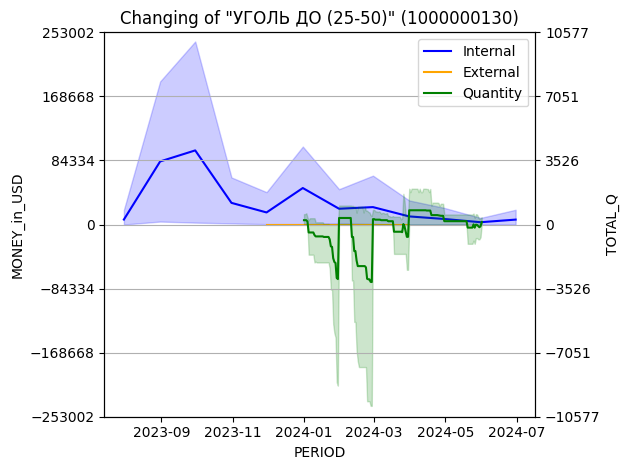

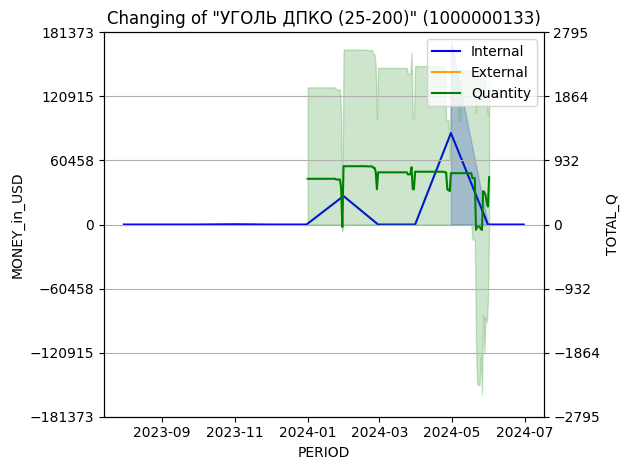

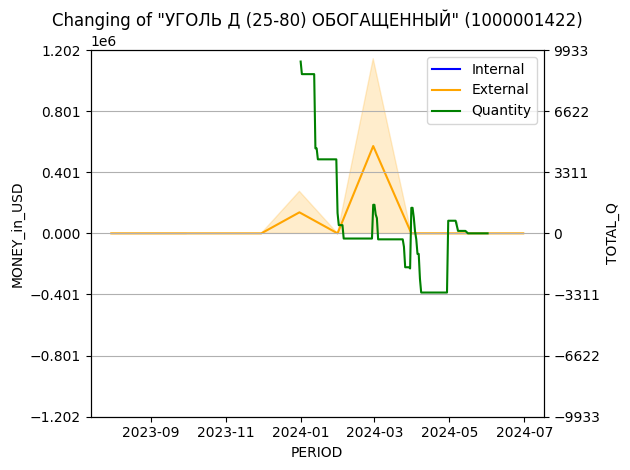

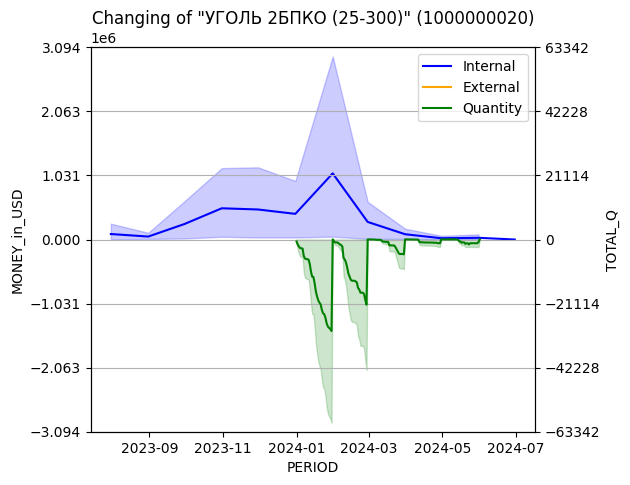

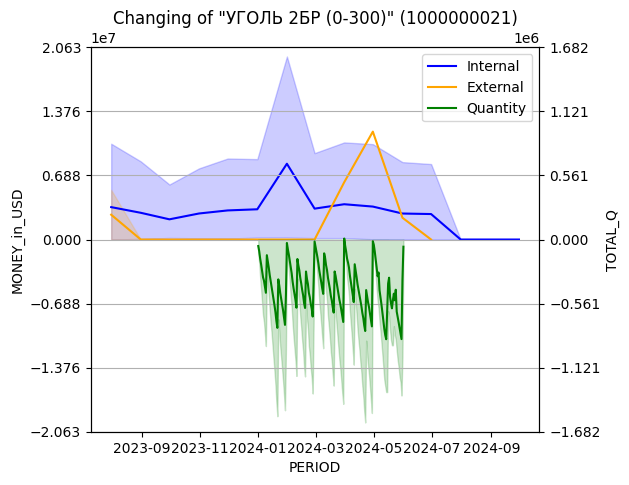

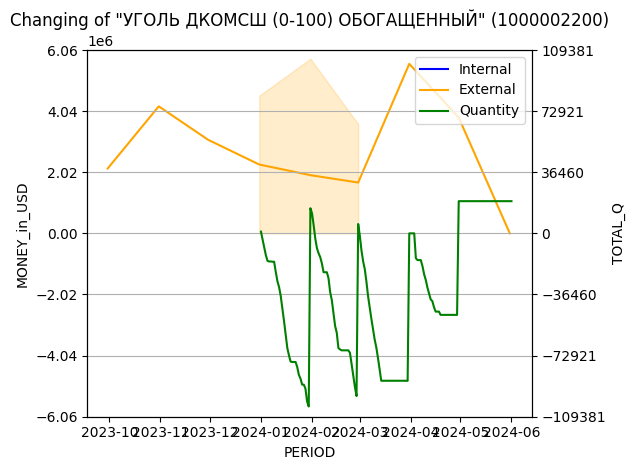

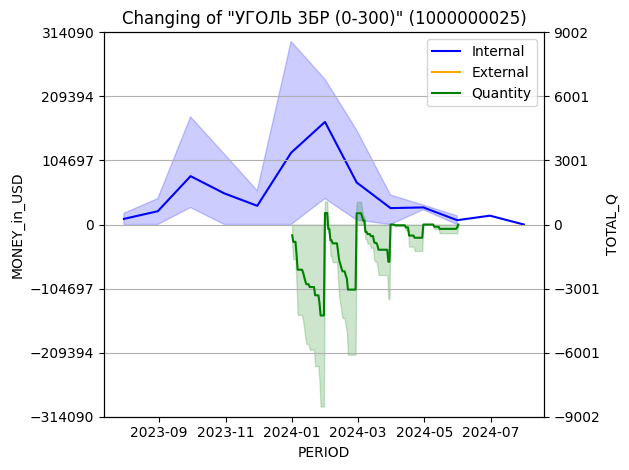

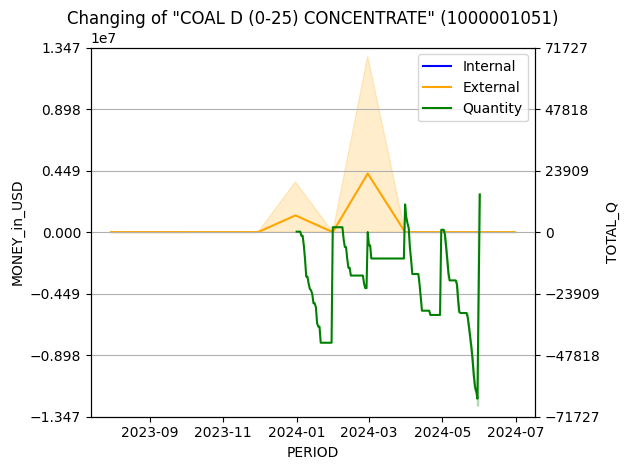

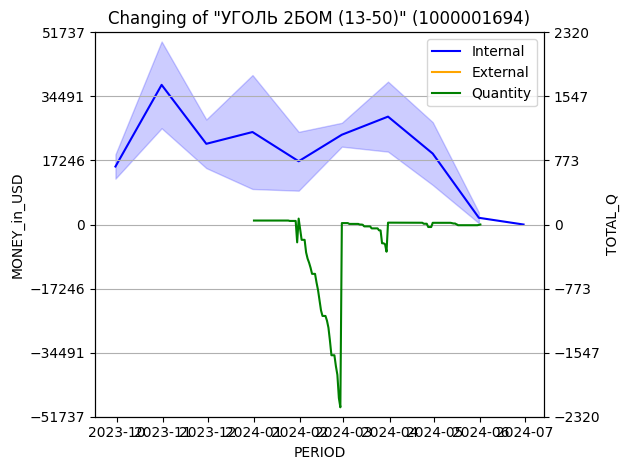

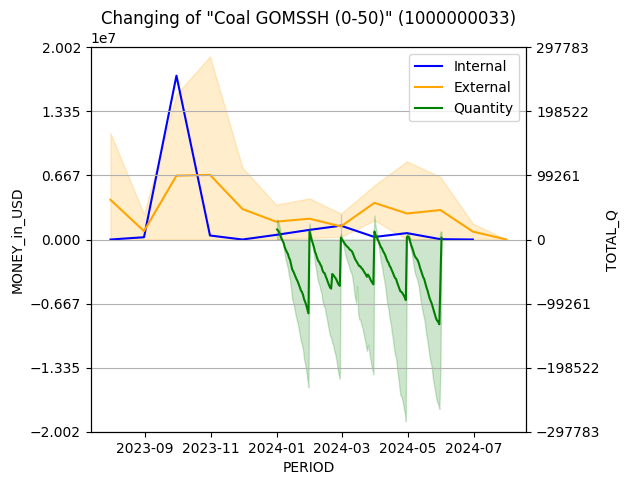

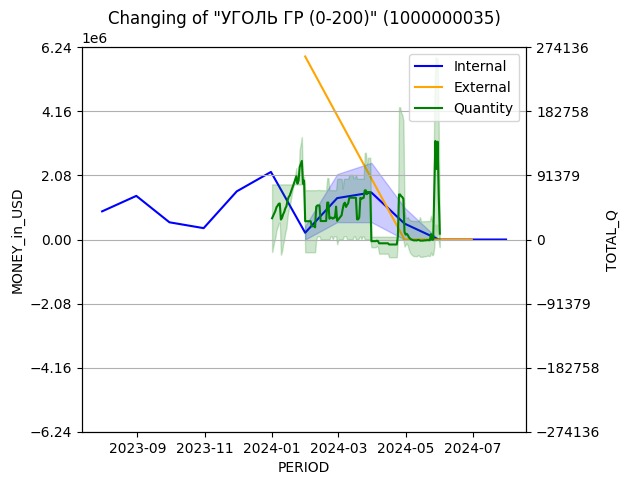

In [214]:
print_png_dict = {}
string_counter = 2
for n in range(11):
    # choose data
    data_deals_work_g = data_deals_work[(data_deals_work.materialId==inter_list[n])]
    data_stocks_g = data_stocks[(data_stocks.itemNumber==inter_list[n])]
    # make graphs
    g,g1,g2 = 0,0,0
    g = sns.lineplot(data_deals_work_g[data_deals_work_g.marketType=='Internal'], y = 'MONEY_in_USD', x = 'PERIOD', label='Internal', color='blue',legend=False)
    g1 = sns.lineplot(data_deals_work_g[data_deals_work_g.marketType=='External'], y = 'MONEY_in_USD', x = 'PERIOD', label='External', color='orange',legend=False)
    g2 = sns.lineplot(data_stocks_g, y = 'TOTAL_Q', x = 'sliceDate', label='Quantity', ax=g.axes.twinx(), color='green',legend=False)
    # y nulls on one line
    max1 = np.nanmax(np.abs(g.axes.get_ybound()))
    max2 = np.nanmax(np.abs(g2.axes.get_ybound()))
    nsticks = 7
    g.axes.set_yticks(np.linspace(-max1,max1,nsticks))
    g2.axes.set_yticks(np.linspace(-max2,max2,nsticks))
    # legend, title, grid
    plt.legend(handles=[g.lines[0],g1.lines[1],g2.lines[0]],labels=['Internal','External','Quantity'])
    plt.title(f'Changing of "{data_deals_work_g.materialName.unique().tolist()[0]}" ({inter_list[n]})')
    plt.grid()

    # save
    if Print_to_excel==True:
        plt.tight_layout()
        name = f'{n}.png'
        plt.savefig(name)
        plt.show() # clear figure

        print_png_dict[name] = string_counter
        string_counter += 26

In [222]:
### to excel
if Print_to_excel == True:
    Output_file = f'{str(date.today())}_Coal.xlsx'
    writer = pd.ExcelWriter(Output_file, engine='openpyxl')
    
    data_deals_work_query_pivot.to_excel(writer, index=True, sheet_name='Pivot_data')

    worksheet = writer.sheets['Pivot_data']
    for name in list(print_png_dict.keys()):
        img = openpyxl.drawing.image.Image(name)
        img.anchor = f'H{print_png_dict[name]}'
        worksheet.add_image(img)


In [216]:
data_deals_work_query_pivot = data_deals_work_query_pivot.reset_index()
data_deals_work_query_pivot

,materialId,materialName,marketType,COUNTERPARTY_COUNTRY,MONEY_in_USD
0,1000000021,УГОЛЬ 2БР (0-300),Internal,RU,4.277023e+08
1,1000001230,COAL G (0-50) WASHED,External,AE,1.498727e+08
2,1000000071,УГОЛЬ Г (0-100) КОНЦЕНТРАТ,External,RU,1.123688e+08
3,1000000055,УГОЛЬ ДОМСШ (0-50),External,RU,8.079633e+07
4,1000000040,УГОЛЬ ДГОМСШ (0-50),External,RU,7.868876e+07
...,...,...,...,...,...
202,1000000057,WĘGIEL 50-200 MM,External,PL,0.000000e+00
203,1000001211,COAL G (0-25) WASHED,External,AE,0.000000e+00
204,1000001110,УГОЛЬ Д (13-60) КОНЦЕНТРАТ,External,TW,0.000000e+00
205,1000001110,COAL D (13-60) CONCENTRAT,External,AE,0.000000e+00


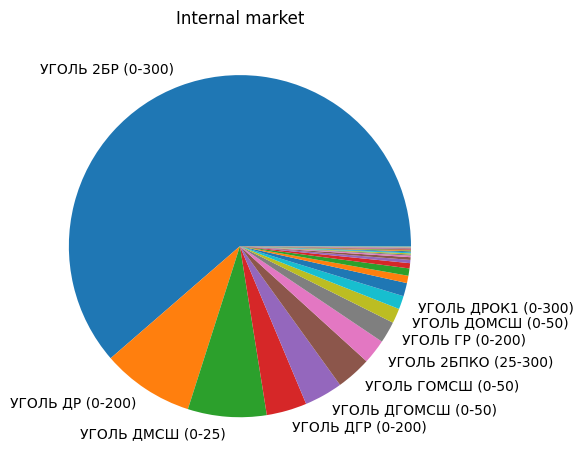

In [217]:
data_g_in = data_deals_work_query_pivot[data_deals_work_query_pivot.marketType=='Internal'].sort_values('MONEY_in_USD', ascending=False)
labels = data_g_in.materialName.tolist()[:10] + ['' for i in data_g_in.MONEY_in_USD.tolist()][10:]
plt.pie(data_g_in.MONEY_in_USD, labels=labels)
plt.title('Internal market')
plt.tight_layout()
plt.savefig('Internal.png')
plt.show()


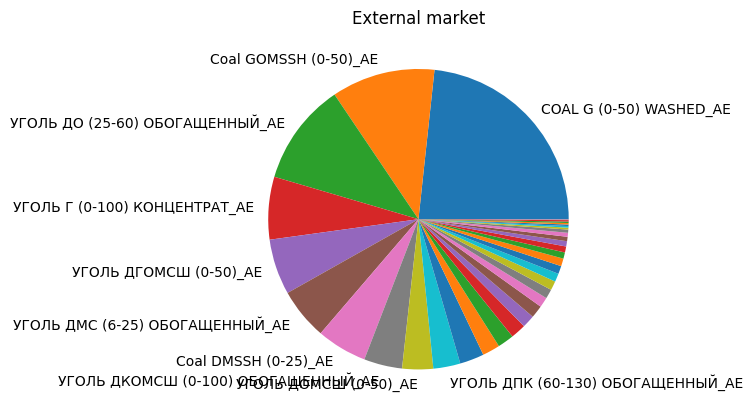

In [218]:
data_g_ex = data_deals_work_query_pivot[(data_deals_work_query_pivot.marketType=='External')&(data_deals_work_query_pivot.COUNTERPARTY_COUNTRY!='RU')].sort_values('MONEY_in_USD', ascending=False)
labels = ['_'.join([x,y]) for x,y in zip(data_g_ex.materialName.astype(str).tolist(), data_g_ex.COUNTERPARTY_COUNTRY.tolist())][:10] + ['' for i in data_g_ex.MONEY_in_USD.tolist()][10:]
plt.pie(data_g_ex.MONEY_in_USD, labels=labels)
plt.title('External market')
plt.tight_layout()
plt.savefig('External.png', bbox_inches='tight')
plt.show()

In [223]:
### to excel
if Print_to_excel == True:
    data_g_in.to_excel(writer, index=False, sheet_name='Internal_market')
    data_g_ex.to_excel(writer, index=False, sheet_name='External_market')
    for market in ['Internal', 'External']:
        worksheet = writer.sheets[f'{market}_market']
        img = openpyxl.drawing.image.Image(f'{market}.png')
        img.anchor = 'H2'
        worksheet.add_image(img)

    writer.close() 